## | 🎯 Analysis                       | ❓ Real Business Question It Answers                                                         |
#### | 📈 Daily/Weekly Trends            | *Is overall demand increasing, cyclical, or declining? When are peaks?*                     |
#### | 📅 Weekday/Monthly Seasonality    | *Do people shop more on weekends? Are there monthly spikes due to paydays or school terms?* |
#### | 🧺 Family-Level Trends            | *Which categories are staples vs seasonal? Which drive the bulk of sales?*                  |
#### | 🏪 Store Behavior                 | *Do urban stores behave differently from suburban? Are clusters coherent?*                  |
#### | 🎉 Promotions & Holidays          | *Do sales spike near holidays? How effective are promotions per family or region?*          |
#### | 🧊 Perishability Risk             | *Which categories are volatile? Which may lead to overstock waste or stockouts?*            |
#### | 📉 Demand Volatility              | *Which SKUs/stores need tighter control or safety stock?*                                   |
#### | 🧠 Correlation w/ Oil or External | *Does demand correlate with oil prices (e.g., delivery/logistics cost)?*                    |


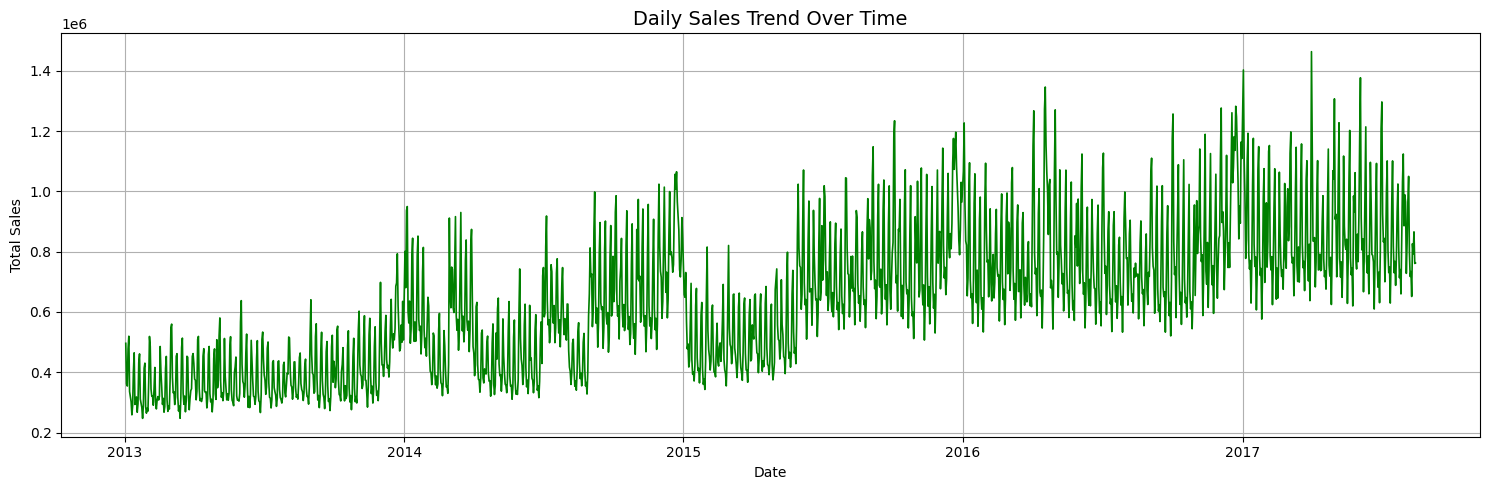

In [54]:
# Daily Sales Trends

import pandas as pd
import matplotlib.pyplot as plt

# Loading cleaned data
train_df = pd.read_csv("../data/processed/cleaned_train.csv", parse_dates=["date"])

# Grouping by date to get total daily sales
daily_sales = train_df.groupby('date')['sales'].sum()

# Plotting daily sales
plt.figure(figsize=(15, 5))
plt.plot(daily_sales.index, daily_sales.values, linewidth=1.2, color = 'green')
plt.title("Daily Sales Trend Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Daily sales display a strong weekly seasonality, with visible peaks and troughs repeating cyclically. We also observe a clear upward growth trend over the years, indicating expanding store activity or product range. Occasional extreme spikes likely correspond to holidays or promotional events, while dips around early January suggest low post-holiday demand.


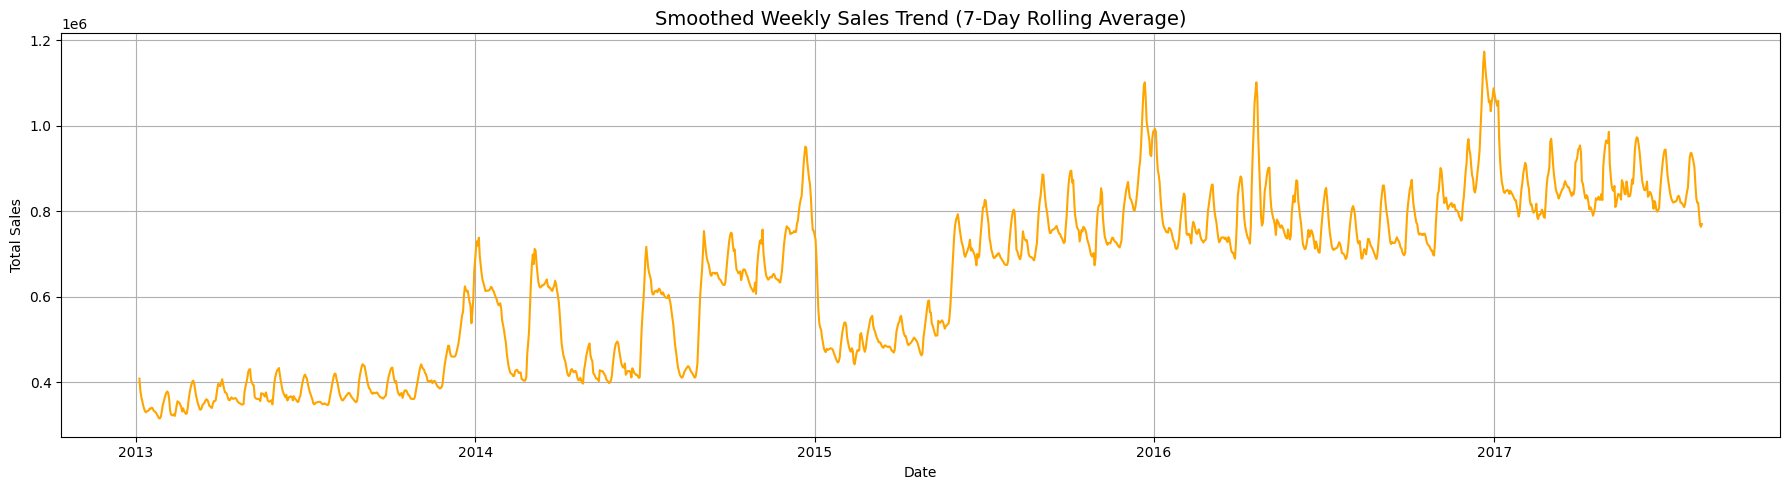

In [55]:
# Smoothed Weekly Sales Trend (7-Day Rolling Mean)

# Applying 7-day rolling average
weekly_trend = daily_sales.rolling(window=7, center=True).mean()

# Plotting
plt.figure(figsize=(18, 5))
plt.plot(weekly_trend, color='orange')
plt.title("Smoothed Weekly Sales Trend (7-Day Rolling Average)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


#### The rolling average reveals growth from 2014 to 2017, clear annual demand surges (holidays, perhaps Q4 peaks) and less noise, better strategic visibility

<Figure size 1200x600 with 0 Axes>

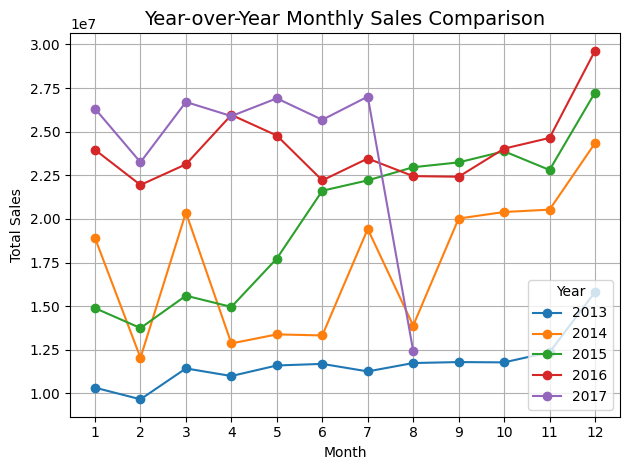

In [56]:
# Year-over-Year monthly sales comparison

# Adding year and month to the DataFrame
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month

# Aggregating monthly total sales by year
monthly_sales = train_df.groupby(['year', 'month'])['sales'].sum().reset_index()

# Pivotting to get years as columns
monthly_pivot = monthly_sales.pivot(index='month', columns='year', values='sales')

# Plotting
plt.figure(figsize=(12, 6))
monthly_pivot.plot(marker='o')
plt.title("Year-over-Year Monthly Sales Comparison", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(ticks=range(1, 13))
plt.legend(title="Year")
plt.grid(True)
plt.tight_layout()
plt.show()


##### Strong upward trend from 2013 to 2017: ~3× growth in December sales.
##### December & July consistently spike — likely due to holidays and seasonal events.
##### February dips each year — aligns with fewer days & post-holiday slowdowns.
##### 2017 August drop: Indicates possible anomaly (e.g., data cutoff, missing values).

## Perishable vs. Non-Perishable Behavior Analysis
##### To understand if - Are perishables more volatile in sales?

#####                    Do promotions impact perishables more?

#####                    When do perishables peak (e.g., holidays, weekends)?

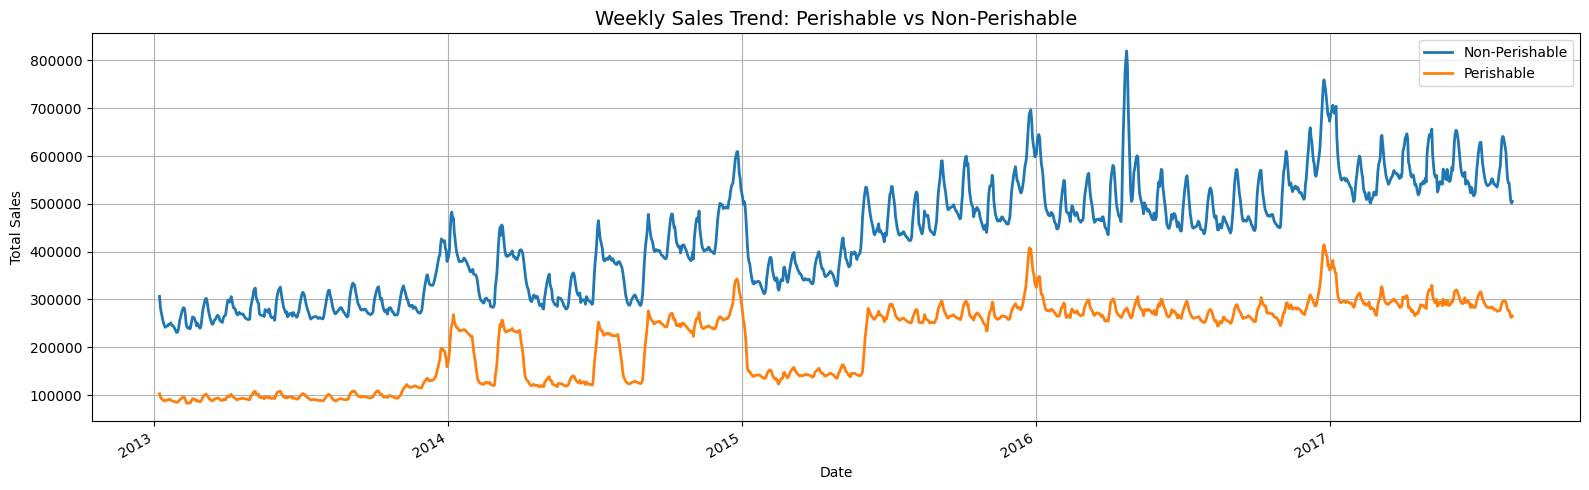

In [57]:
# Weekly sales trends by perishability

# Grouping by date and perishability
weekly_sales = train_df.groupby(['date', 'is_perishable'])['sales'].sum().unstack()

# Applying 7-day rolling mean
weekly_sales_rolling = weekly_sales.rolling(7).mean()

# Plotting
plt.figure(figsize=(16,5))
weekly_sales_rolling.plot(ax=plt.gca(), linewidth=2)
plt.title("Weekly Sales Trend: Perishable vs Non-Perishable", fontsize=14)
plt.ylabel("Total Sales")
plt.xlabel("Date")
plt.legend(["Non-Perishable", "Perishable"])
plt.grid(True)
plt.tight_layout()
plt.show()

#### Non-perishable goods consistently drive higher total sales and show clearer weekly seasonality patterns.
#### Perishables, while lower in volume, still show seasonal uplift — likely tied to holidays and short shelf-life restocking cycles.

In [58]:
# Promotion impact

# The `onpromotion` column reflects the number of items in a family on promotion per store-date, but not which specific items were sold — creating a granularity mismatch.  
# To address this, we use `onpromotion` as a proxy signal for family-level promotional intensity in both EDA and modeling.


# Feature Engineering
# promo_intensity - Ratio of promoted items to a benchmark (e.g. total items in family)
# is_heavy_promo_day - Binary: 1 if above threshold (e.g. >10 promos)
# normalized_promo - Onpromotion count normalized per store-family

# Normalizing promo count across all families
train_df['normalized_promo'] = train_df.groupby('family')['onpromotion'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
)

# Simple promo intensity thresholds
train_df['is_heavy_promo_day'] = (train_df['onpromotion'] > 10).astype(int)

# promo_ratio within a store on that day (relative)
store_day_total = train_df.groupby(['store_nbr', 'date'])['onpromotion'].transform('sum')
train_df['promo_ratio_in_store'] = train_df['onpromotion'] / (store_day_total + 1e-6)



C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


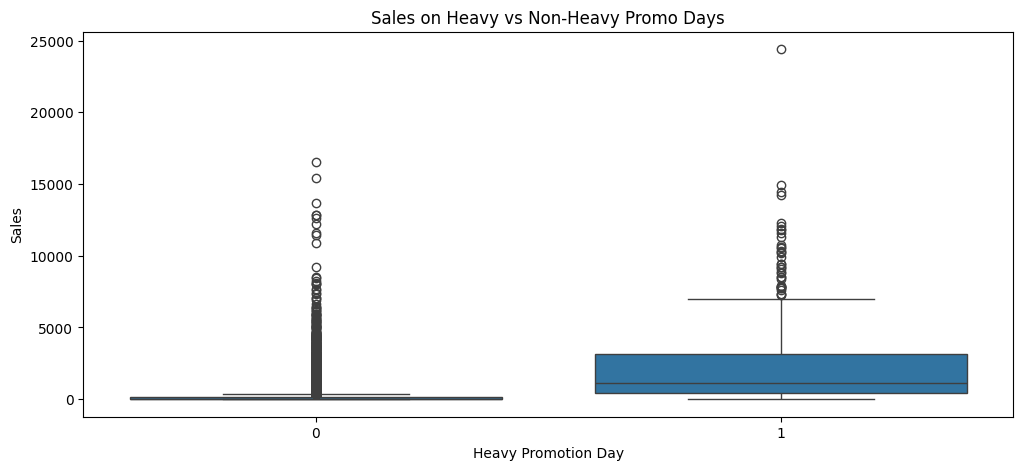

In [59]:
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.boxplot(x='is_heavy_promo_day', y='sales', data=train_df.sample(10000))
plt.title("Sales on Heavy vs Non-Heavy Promo Days")
plt.xlabel("Heavy Promotion Day")
plt.ylabel("Sales")
plt.show()


##### Heavy promotion days show significantly higher median and upper-range sales compared to non-promo days, indicating strong uplift from promotional activity.
##### This validates onpromotion as a reliable proxy signal for capturing promo-driven demand surges.

## Weekly Sales Pattern (Day of Week)
##### To optimize iventory and staffing by day
##### Promos can be aligned to high-traffic days.
##### Weekly seasonality helps train better time-aware models.

C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\2750610915.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekday_sales, x='day_name', y='sales', palette='viridis')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_gro

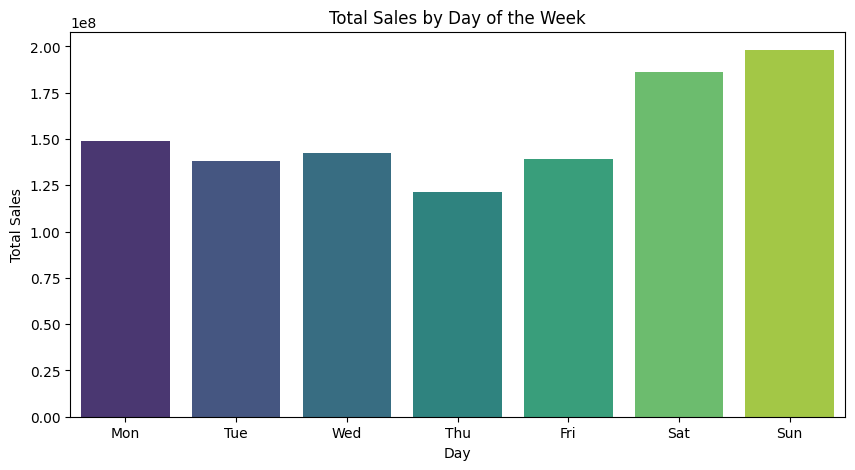

In [60]:
# Creating weekday column
train_df['day_of_week'] = train_df['date'].dt.dayofweek  # Monday = 0, Sunday = 6

# Aggregating sales per weekday
weekday_sales = train_df.groupby('day_of_week')['sales'].sum().reset_index()

# Mapping day numbers to names for better readability
weekday_sales['day_name'] = weekday_sales['day_of_week'].map({
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'
})

# Sorting by actual weekday order
weekday_sales = weekday_sales.sort_values('day_of_week')

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=weekday_sales, x='day_name', y='sales', palette='viridis')
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.show()


##### Sales spike on weekends, especially Sunday, with Saturday close behind.
##### Thursday appears to be the slowest day — a potential promo opportunity.

## Monthly Seasonality
##### To explore if certain months drive more sales due to
##### - Pay cycles (start/end of month)
##### - Back-to-school (Aug/Sep)
##### - Holidays (Nov/Dec)

C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\4223899151.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_sales, x='month', y='sales', palette='crest')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in 

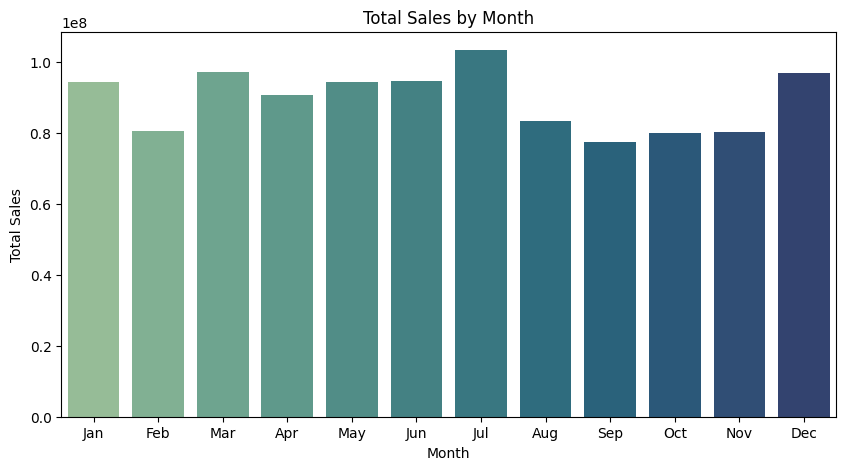

In [61]:
# Creating month column
train_df['month'] = train_df['date'].dt.month

# Aggregating monthly sales
monthly_sales = train_df.groupby('month')['sales'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_sales, x='month', y='sales', palette='crest')
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(0, 12), [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.show()

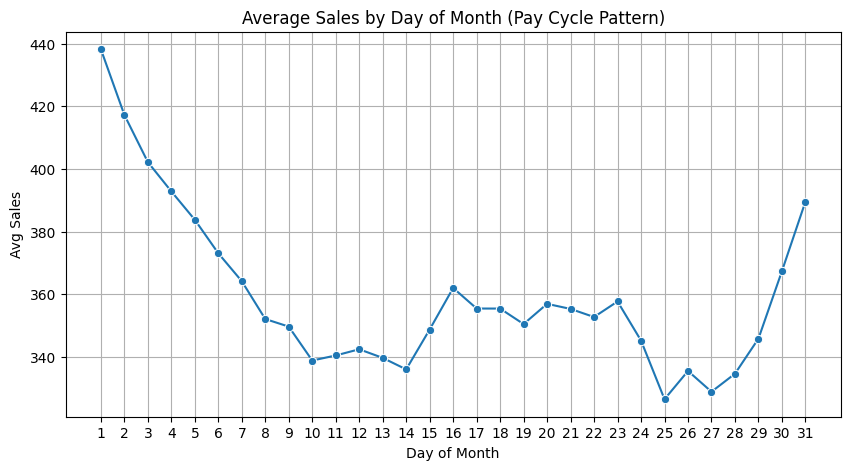

In [62]:
# Detecting Pay Cycle Patterns

# Extracting day of month
train_df['day_of_month'] = train_df['date'].dt.day

# Averaging sales per day across all months
dom_sales = train_df.groupby('day_of_month')['sales'].mean().reset_index()

# Plotting line
plt.figure(figsize=(10, 5))
sns.lineplot(data=dom_sales, x='day_of_month', y='sales', marker='o')
plt.title('Average Sales by Day of Month (Pay Cycle Pattern)')
plt.xlabel('Day of Month')
plt.ylabel('Avg Sales')
plt.xticks(range(1, 32))
plt.grid(True)
plt.show()


#### Monthly Sales Pattern
##### Sales peak during July and December, hinting at seasonal or holiday-driven demand surges, while August to November show relatively lower activity, possibly a post-summer slump.

#### Average Sales by Day of Month (Pay Cycle Pattern)
##### There’s a clear spike in sales during the start and end of each month, likely influenced by pay cycles, with mid-month showing a noticeable dip in consumer activity.

## Store-Level Seasonality & Volatility
#### To check for 
##### - High vs low performing stores
##### - Unique seasonality patterns in certain cities or store types
##### - Volatility or instability in store performance (important for stock planning)

C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\2016765989.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=store_sales.index, y=store_sales.values, palette='viridis')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group 

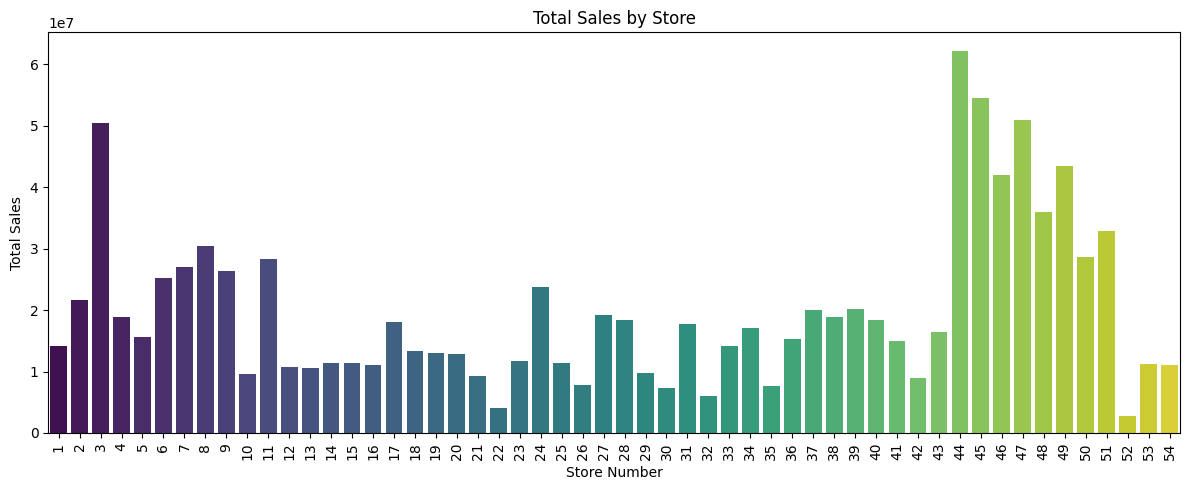

In [63]:
# Plotting total sales per store
store_sales = train_df.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=store_sales.index, y=store_sales.values, palette='viridis')
plt.title("Total Sales by Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [64]:
# Retrieving Top & Bottom 5 Stores along with their metadata for geographical analysis

# Aggregating total sales per store
store_sales_summary = (
    train_df.groupby('store_nbr')['sales']
    .sum()
    .reset_index()
    .sort_values(by='sales', ascending=False)
)

# Merging with store metadata (type, city)
store_metadata = train_df[['store_nbr', 'type', 'city']].drop_duplicates()

store_sales_enriched = store_sales_summary.merge(store_metadata, on='store_nbr', how='left')

# Getting top 5 and bottom 5
top_5_stores = store_sales_enriched.head(5)
bottom_5_stores = store_sales_enriched.tail(5)

# Displaying results
pd.set_option('display.max_colwidth', None)

print(" Top 5 High-Performing Stores:\n", top_5_stores)
print("\n Bottom 5 Low-Performing Stores:\n", bottom_5_stores)


 Top 5 High-Performing Stores:
    store_nbr         sales type   city
0         44  6.208755e+07    A  Quito
1         45  5.449801e+07    A  Quito
2         47  5.094831e+07    A  Quito
3          3  5.048191e+07    D  Quito
4         49  4.342010e+07    A  Quito

 Bottom 5 Low-Performing Stores:
     store_nbr         sales type       city
49         35  7.676679e+06    C     Playas
50         30  7.382074e+06    C  Guayaquil
51         32  5.951796e+06    C  Guayaquil
52         22  4.090202e+06    C       Puyo
53         52  2.696170e+06    A      Manta


#### Top-performing stores are concentrated in Quito, especially Store Type A, likely due to higher urban footfall and economic activity.
#### Lowest-performing stores are mainly smaller Type C outlets in cities like Puyo and Playas, reflecting rural demand limitations or lower population density.

## Family-Level Seasonality Trends

C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\960702693.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=family_sales.values, y=family_sales.index, palette='viridis')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group

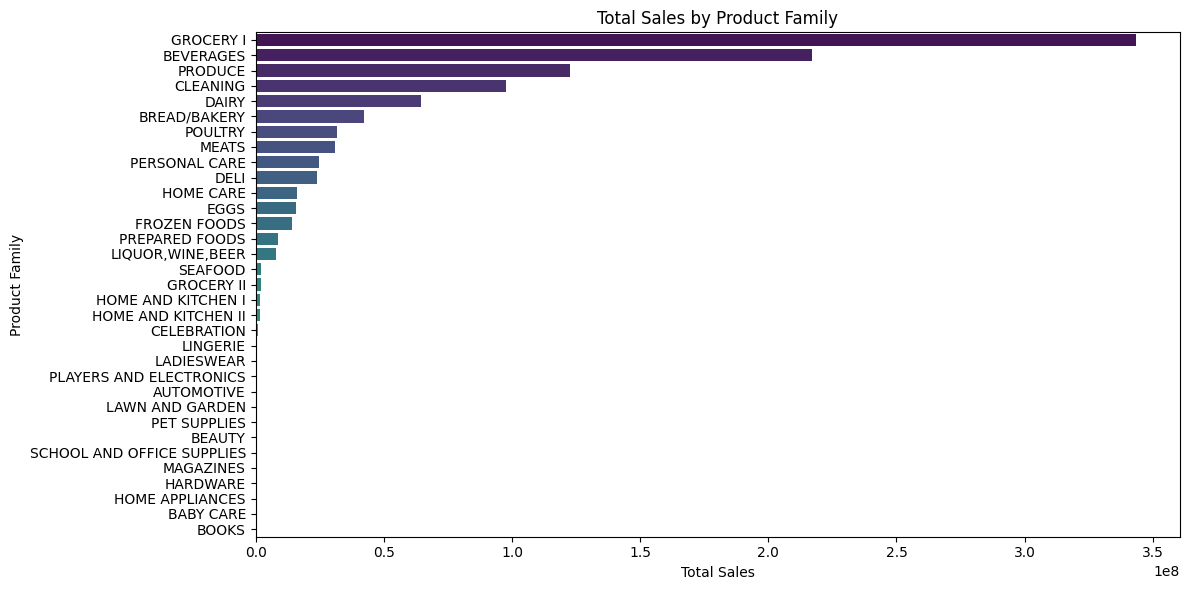

In [65]:
family_sales = train_df.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=family_sales.values, y=family_sales.index, palette='viridis')
plt.title("Total Sales by Product Family")
plt.xlabel("Total Sales")
plt.ylabel("Product Family")
plt.tight_layout()
plt.show()

##### Sales are heavily concentrated in a few essential categories — Grocery I, Beverages, and Produce dominate overall demand, indicating they are staple purchases. Conversely, categories like Books, Baby Care, and Home Appliances contribute minimally, showing niche or occasional demand.

C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

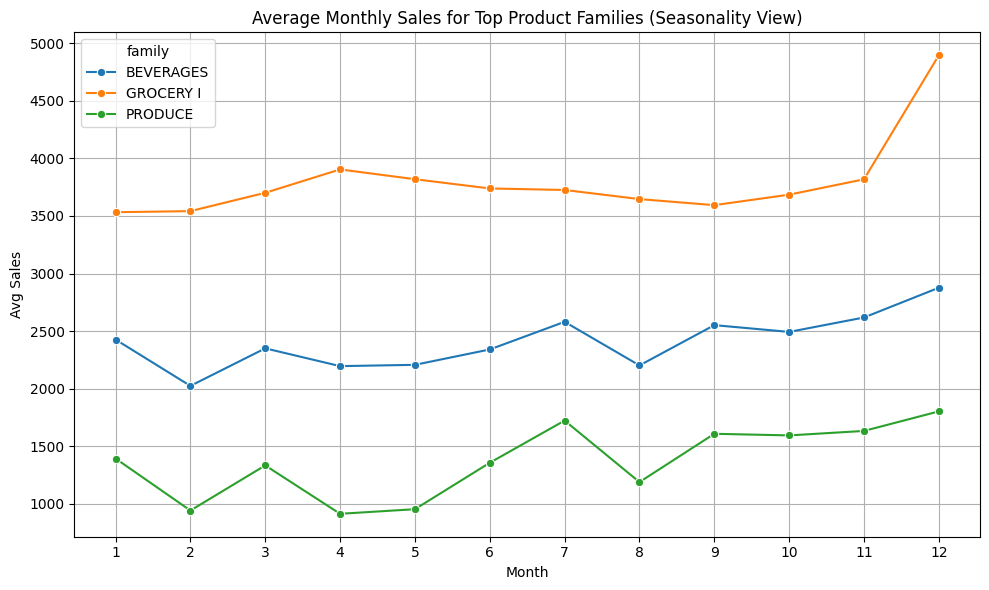

In [66]:
# Seasonality in Top Families

top_families = family_sales.head(3).index.tolist()

# Extract month from date
train_df['month'] = train_df['date'].dt.month

# Group by family and month to get average sales
monthly_family_sales = (
    train_df[train_df['family'].isin(top_families)]
    .groupby(['family', 'month'])['sales']
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=monthly_family_sales,
    x='month',
    y='sales',
    hue='family',
    marker='o'
)
plt.title("Average Monthly Sales for Top Product Families (Seasonality View)")
plt.xlabel("Month")
plt.ylabel("Avg Sales")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()



##### GROCERY I and BEVERAGES exhibit strong year-end seasonality, with sales peaking in December — likely driven by holiday demand and festive stocking.
##### PRODUCE shows mild cyclicality, with a slight uptick mid-year and year-end, indicating fresh food preferences aligned with seasonal availability or events.

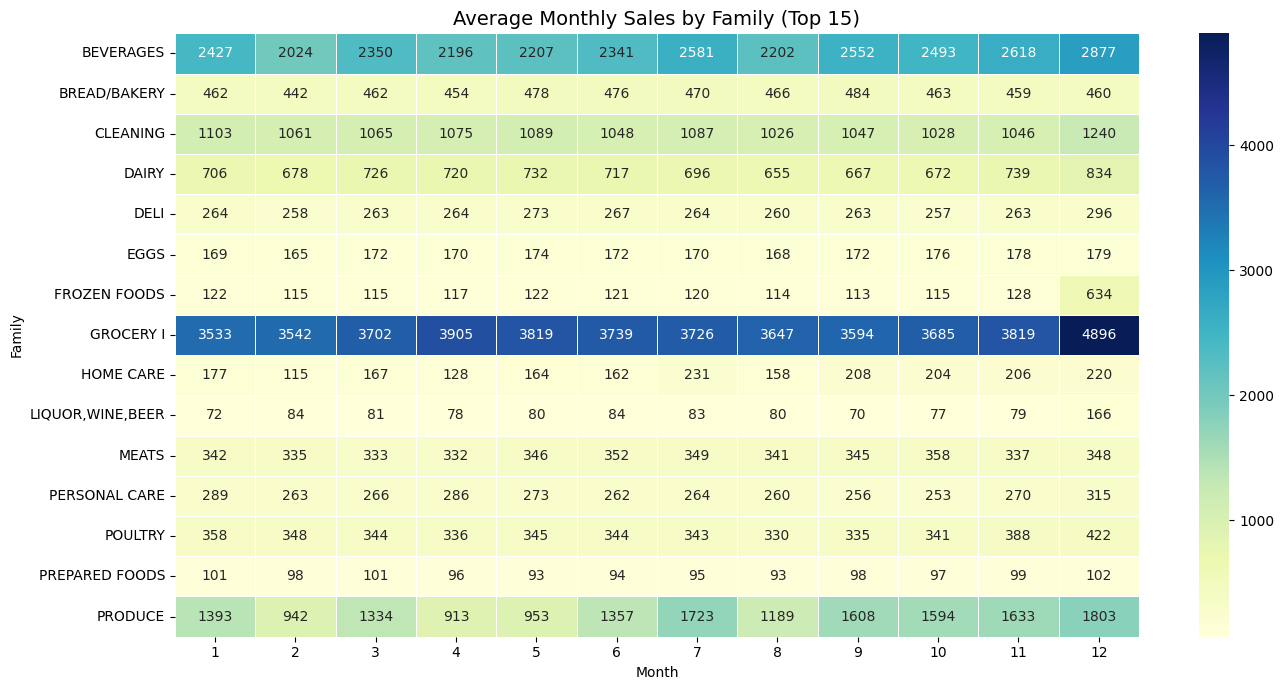

In [67]:
# Heatmap for Top 15 Families

# Step 1: Extract month from date
train_df['month'] = pd.to_datetime(train_df['date']).dt.month

# Step 2: Identify Top 15 families by total sales
top_families = train_df.groupby('family')['sales'].sum().sort_values(ascending=False).head(15).index.tolist()

# Step 3: Filter and pivot data
filtered_df = train_df[train_df['family'].isin(top_families)]
monthly_sales = (
    filtered_df.groupby(['family', 'month'])['sales']
    .mean()
    .reset_index()
    .pivot(index='family', columns='month', values='sales')
)

# Step 4: Plot heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(monthly_sales, cmap='YlGnBu', linewidths=0.5, annot=True, fmt=".0f")
plt.title('Average Monthly Sales by Family (Top 15)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Family')
plt.tight_layout()
plt.show()

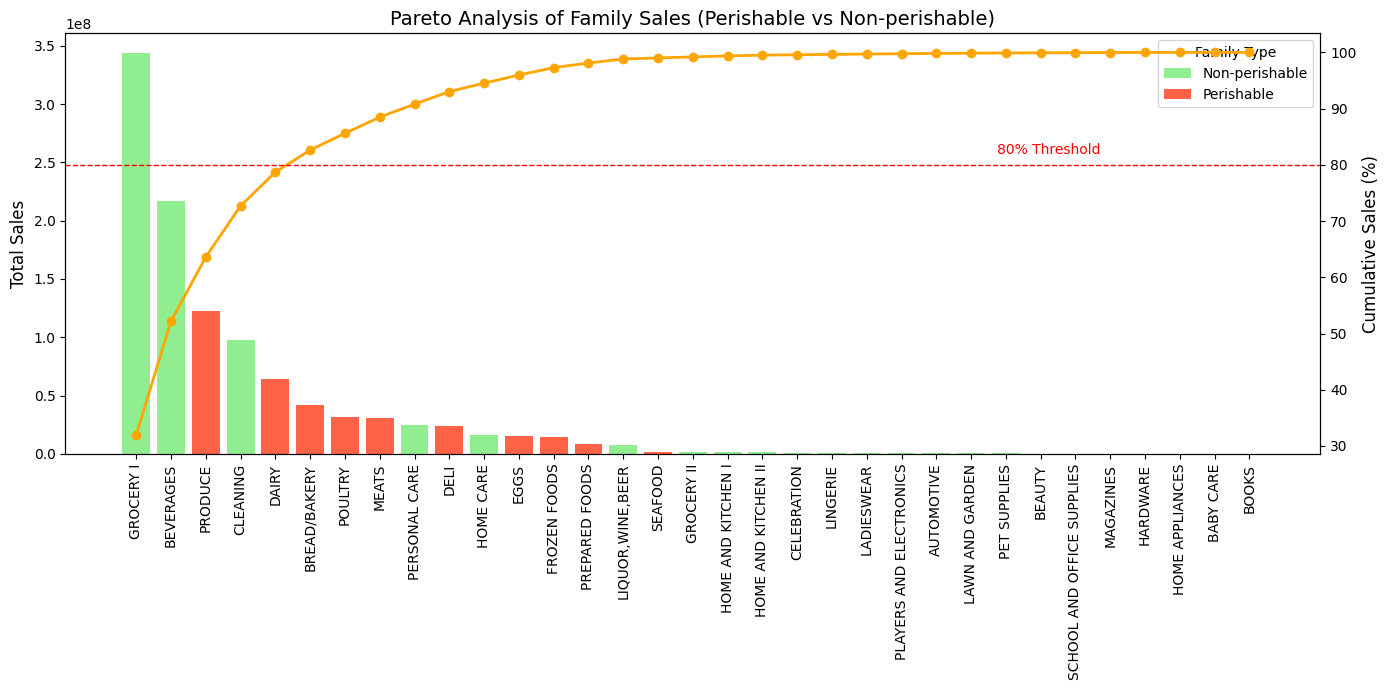

In [68]:
# Pareto chart will help identify the "vital few" families that drive the majority of sales

family_sales = (
    train_df.groupby(['family', 'is_perishable'])['sales']
    .sum()
    .reset_index()
    .sort_values('sales', ascending=False)
    .reset_index(drop=True)
)

# Step 2: Calculate cumulative sales and % contribution
family_sales['cumulative_sales'] = family_sales['sales'].cumsum()
family_sales['cumulative_pct'] = 100 * family_sales['cumulative_sales'] / family_sales['sales'].sum()

# Step 3: Set colors based on perishability
color_map = {0: 'lightgreen', 1: 'tomato'}  # Customize if you'd like
bar_colors = family_sales['is_perishable'].map(color_map)

# Step 4: Plot Pareto chart
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot of total sales
ax1.bar(family_sales['family'], family_sales['sales'], color=bar_colors)
ax1.set_ylabel('Total Sales', fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# Line plot of cumulative %
ax2 = ax1.twinx()
ax2.plot(family_sales['family'], family_sales['cumulative_pct'], color='orange', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Sales (%)', fontsize=12)
ax2.axhline(80, color='red', linestyle='--', linewidth=1)
ax2.text(len(family_sales)*0.75, 82, '80% Threshold', color='red')

# Title
plt.title('Pareto Analysis of Family Sales (Perishable vs Non-perishable)', fontsize=14)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgreen', label='Non-perishable'),
    Patch(facecolor='tomato', label='Perishable')
]
ax1.legend(handles=legend_elements, title='Family Type', loc='upper right')

plt.tight_layout()
plt.show()

#### GROCERY I, BEVERAGES, PRODUCE, CLEANING, and DAIRY contribute to over 80% of total sales, showcasing a classic Pareto pattern where a few categories drive the bulk of revenue.
#### High-volume families are predominantly perishable, indicating the need for tight supply chain coordination, particularly around cold storage, replenishment frequency, and spoilage risk mitigation.

## Store Behavior Analysis
#### -Analyze whether urban stores behave differently from suburban/rural ones
#### -Recognizing Trends based on store-type or location

C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\818050281.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=store_sales, x='type', y='sales', palette='Set2')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positi

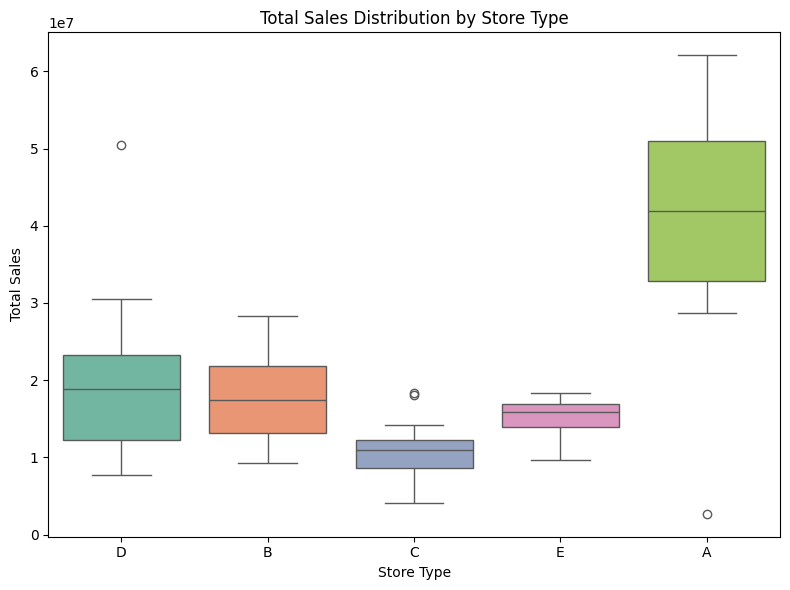

In [69]:
# Boxplot: Total Sales by Store Type

store_sales = train_df.groupby(['store_nbr', 'type'])['sales'].sum().reset_index()

# Plotting boxplot by store type
plt.figure(figsize=(8, 6))
sns.boxplot(data=store_sales, x='type', y='sales', palette='Set2')
plt.title('Total Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

In [70]:
# Identifying whether the overperforming outlier stores (per store type) are from either the top 5 cities or bottom 5 cities by total sales

# Top and bottom 5 cities
city_sales = train_df.groupby('city')['sales'].sum().sort_values(ascending=False)
top_5_cities = city_sales.head(5).index.tolist()
bottom_5_cities = city_sales.tail(5).index.tolist()

# Total sales per store with type and city
store_info = train_df.groupby(['store_nbr', 'type', 'city'])['sales'].sum().reset_index()

# Identifying overperformers per type using IQR method
overperformers = []

for t in store_info['type'].unique():
    subset = store_info[store_info['type'] == t]
    q1 = subset['sales'].quantile(0.25)
    q3 = subset['sales'].quantile(0.75)
    iqr = q3 - q1
    threshold = q3 + 1.5 * iqr
    
    # Filter overperforming outliers
    outliers = subset[subset['sales'] > threshold]
    overperformers.append(outliers)

# Combine all outliers
overperforming_stores = pd.concat(overperformers)

# Tagging whether each overperformer is from a top or bottom city
overperforming_stores['city_tag'] = overperforming_stores['city'].apply(
    lambda x: 'Top City' if x in top_5_cities else 'Bottom City' if x in bottom_5_cities else 'Other'
)

overperforming_stores.head(10)  # or .to_csv() or display() if using Jupyter


,store_nbr,type,city,sales,city_tag
2,3,D,Quito,5.048191e+07,Top City
16,17,C,Quito,1.803097e+07,Top City
39,40,C,Machala,1.839576e+07,Other


C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

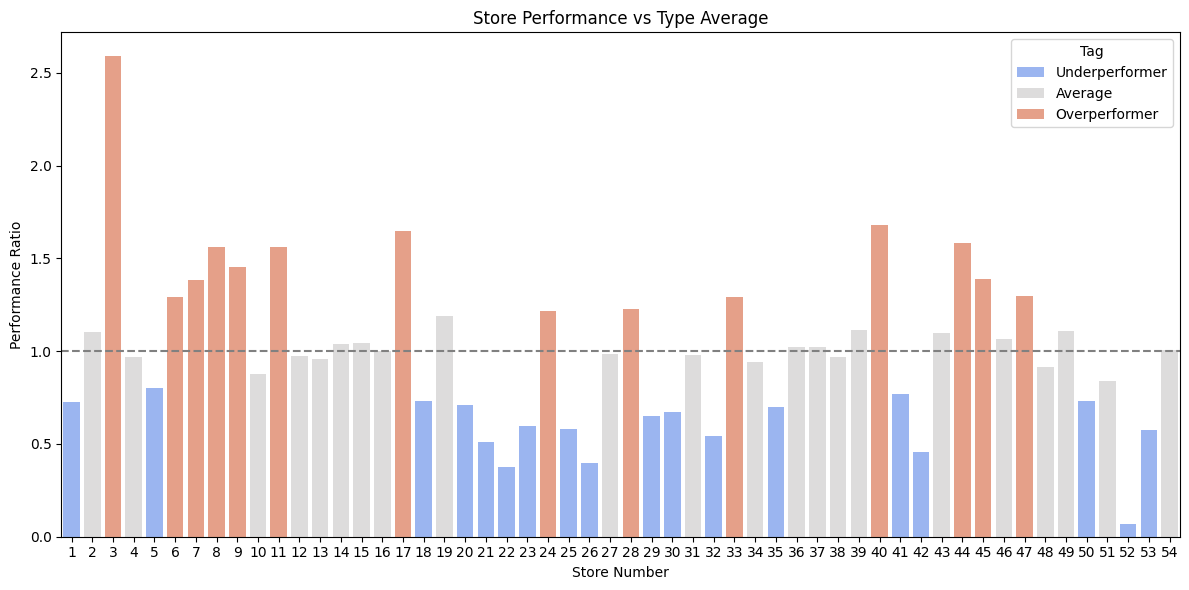

In [71]:
# Step 1: Mean sales per store and type
store_perf = train_df.groupby(['store_nbr', 'type'])['sales'].sum().reset_index()

# Step 2: Add type-level mean for comparison
type_avg = store_perf.groupby('type')['sales'].mean().reset_index().rename(columns={'sales': 'type_avg'})
store_perf = store_perf.merge(type_avg, on='type')
store_perf['performance_ratio'] = store_perf['sales'] / store_perf['type_avg']

# Step 3: Flag over/under performers
store_perf['performance_tag'] = store_perf['performance_ratio'].apply(
    lambda x: 'Overperformer' if x > 1.2 else 'Underperformer' if x < 0.8 else 'Average'
)

# Step 4: Visual
plt.figure(figsize=(12, 6))
sns.barplot(data=store_perf, x='store_nbr', y='performance_ratio', hue='performance_tag', dodge=False, palette='coolwarm')
plt.axhline(1.0, linestyle='--', color='gray')
plt.title('Store Performance vs Type Average')
plt.xlabel('Store Number')
plt.ylabel('Performance Ratio')
plt.legend(title='Tag')
plt.tight_layout()
plt.show()


C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\3221593666.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_sales.index, y=city_sales.values, palette='Blues_d')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in

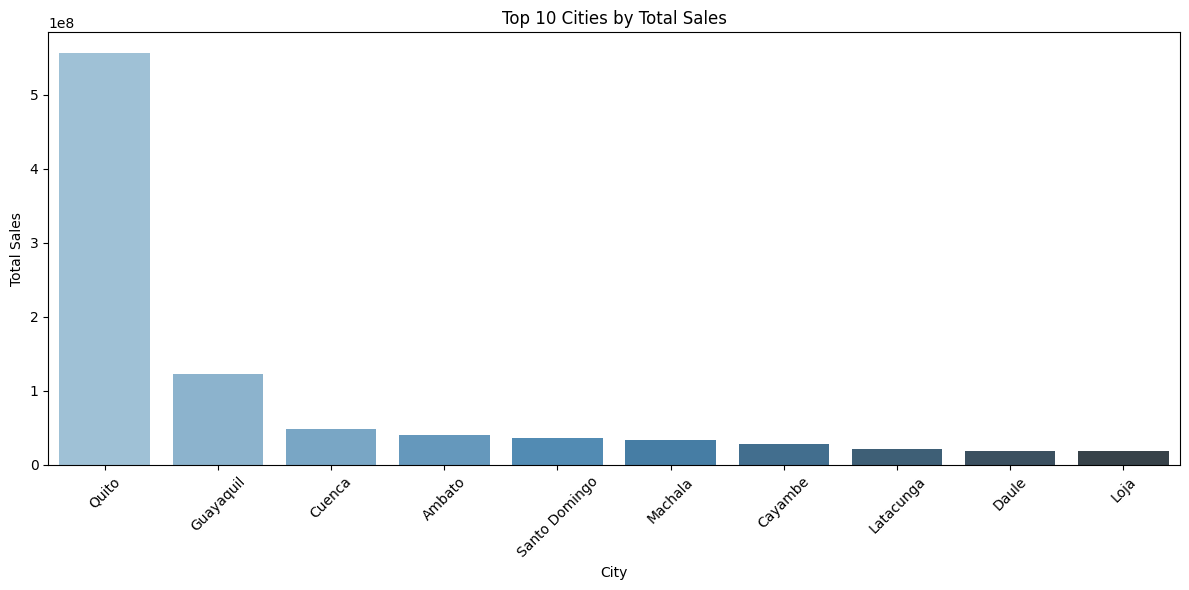

In [72]:
# Step 1: Aggregate sales by city
city_sales = train_df.groupby('city')['sales'].sum().sort_values(ascending=False).head(10)

# Step 2: Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=city_sales.index, y=city_sales.values, palette='Blues_d')
plt.title('Top 10 Cities by Total Sales')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


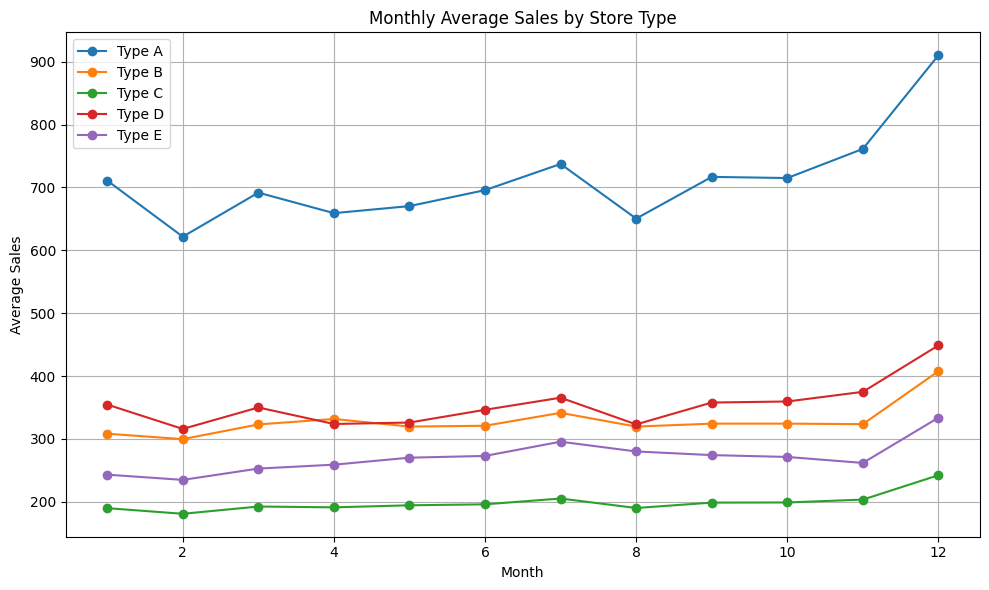

In [73]:
# Step 1: Extract month
train_df['month'] = pd.to_datetime(train_df['date']).dt.month

# Step 2: Group sales by store type and month
monthly_type_sales = (
    train_df.groupby(['type', 'month'])['sales']
    .mean()
    .reset_index()
)

# Step 3: Plot line chart
plt.figure(figsize=(10, 6))
for t in monthly_type_sales['type'].unique():
    subset = monthly_type_sales[monthly_type_sales['type'] == t]
    plt.plot(subset['month'], subset['sales'], marker='o', label=f'Type {t}')

plt.title('Monthly Average Sales by Store Type')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Promotions & Holiday/Event Spikes

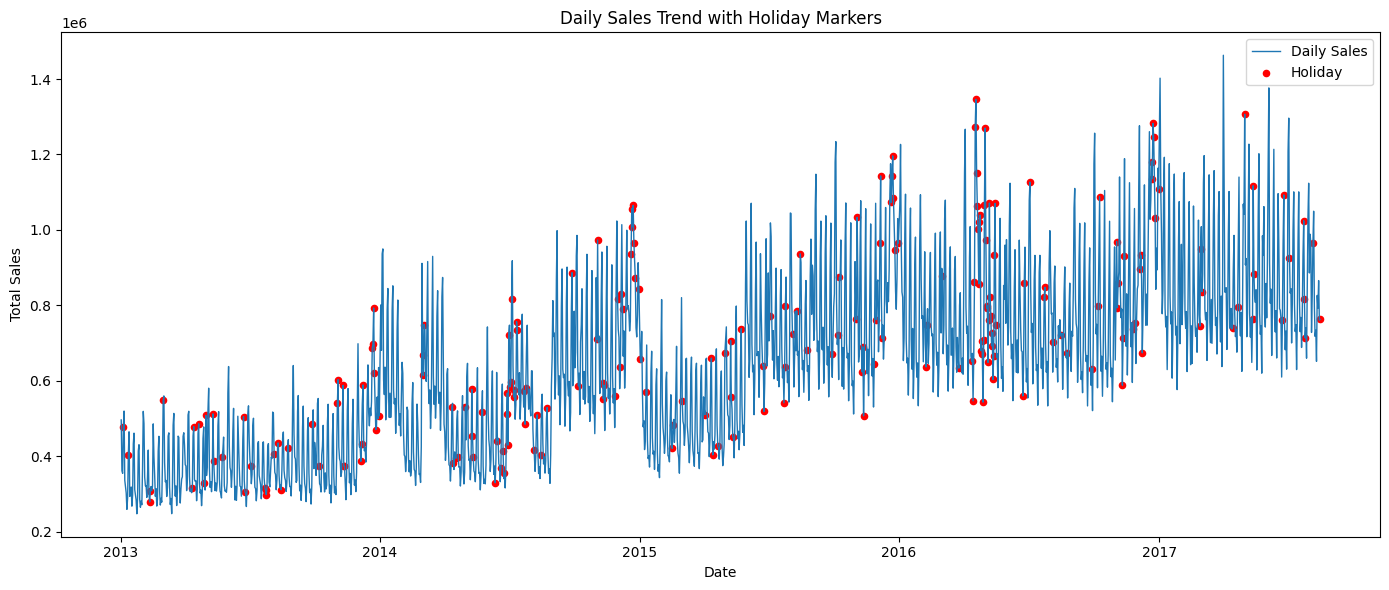

In [74]:
# Sales over Time with Holiday overlay

# Step 1: Daily total sales
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()

# Optional: Add holiday tag
# If 'is_holiday' not already in train_df, skip this line or adjust
if 'is_holiday' in train_df.columns:
    holiday_dates = train_df[train_df['is_holiday'] == True]['date'].unique()
    daily_sales['is_holiday'] = daily_sales['date'].isin(holiday_dates)

# Step 2: Plot
plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(daily_sales['date']), daily_sales['sales'], label='Daily Sales', linewidth=1)
if 'is_holiday' in daily_sales.columns:
    holiday_sales = daily_sales[daily_sales['is_holiday']]
    plt.scatter(pd.to_datetime(holiday_sales['date']), holiday_sales['sales'], color='red', label='Holiday', s=20)

plt.title('Daily Sales Trend with Holiday Markers')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()


##### Holiday markers consistently align with spikes in daily sales, indicating a clear uptick in consumer activity during key events. These spikes are especially noticeable in Q4 each year, suggesting holidays are strong demand drivers.

C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\4251841900.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_comparison, x='is_holiday', y='sales', palette='pastel')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to ge

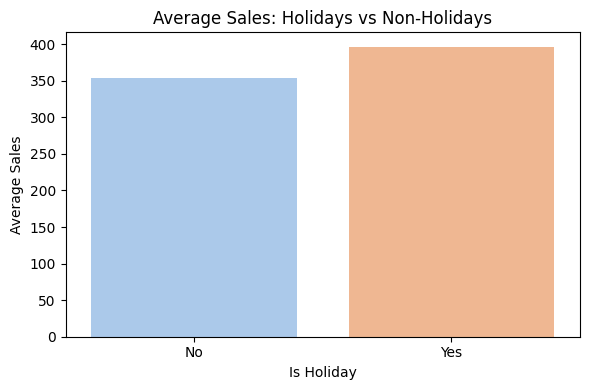

In [75]:
# Avg. Sales on Holidays vs Non-Holidays

# Group by holiday flag
holiday_comparison = train_df.groupby('is_holiday')['sales'].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=holiday_comparison, x='is_holiday', y='sales', palette='pastel')
plt.title('Average Sales: Holidays vs Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Average Sales')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()


##### On average, sales are slightly higher on holidays than regular days, reinforcing the strategic importance of aligning promotions and inventory planning with the holiday calendar.

C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\3369828820.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promo_effect.index, y=promo_effect['Uplift'], palette='coolwarm')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get

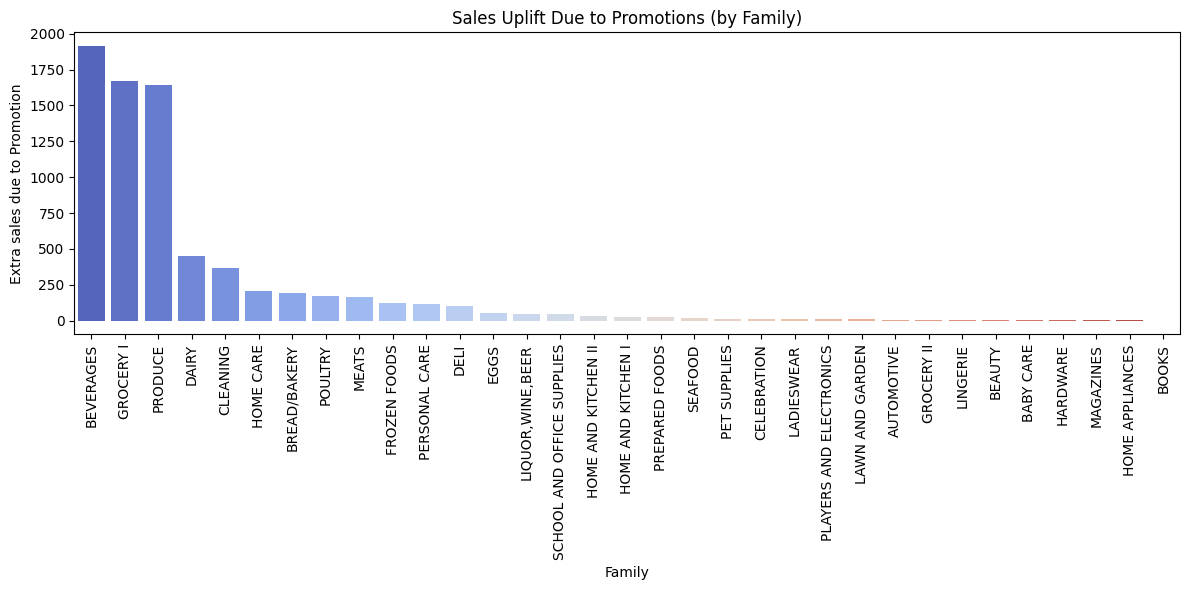

In [76]:


# Step 1: Create binary promotion flag
train_df['on_promo'] = train_df['onpromotion'].apply(lambda x: 1 if x > 0 else 0)

# Step 2: Group by family and promo flag
promo_effect = (
    train_df.groupby(['family', 'on_promo'])['sales']
    .mean()
    .reset_index()
    .pivot(index='family', columns='on_promo', values='sales')
    .fillna(0)
)

# Step 3: Rename columns and calculate uplift
promo_effect.columns = ['No Promo', 'Promo']
promo_effect['Uplift'] = promo_effect['Promo'] - promo_effect['No Promo']
promo_effect = promo_effect.sort_values('Uplift', ascending=False)

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=promo_effect.index, y=promo_effect['Uplift'], palette='coolwarm')
plt.title('Sales Uplift Due to Promotions (by Family)')
plt.xlabel('Family')
plt.ylabel('Extra sales due to Promotion')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


##### Promotions drive significant uplift in high-traffic categories like Beverages, Grocery I, and Produce, with daily sales increasing by up to 2,000 units. In contrast, categories like Books, Home Appliances, and Beauty see negligible gains, suggesting promotion ROI is highly category-dependent.

## Perishability Risk Analysis
##### Highlight perishable families with high volatility, i.e., unstable demand, which puts them at risk of spoilage or frequent stockouts.

C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\470493072.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='family', y='cov', data=family_stats, palette='Reds_r')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a

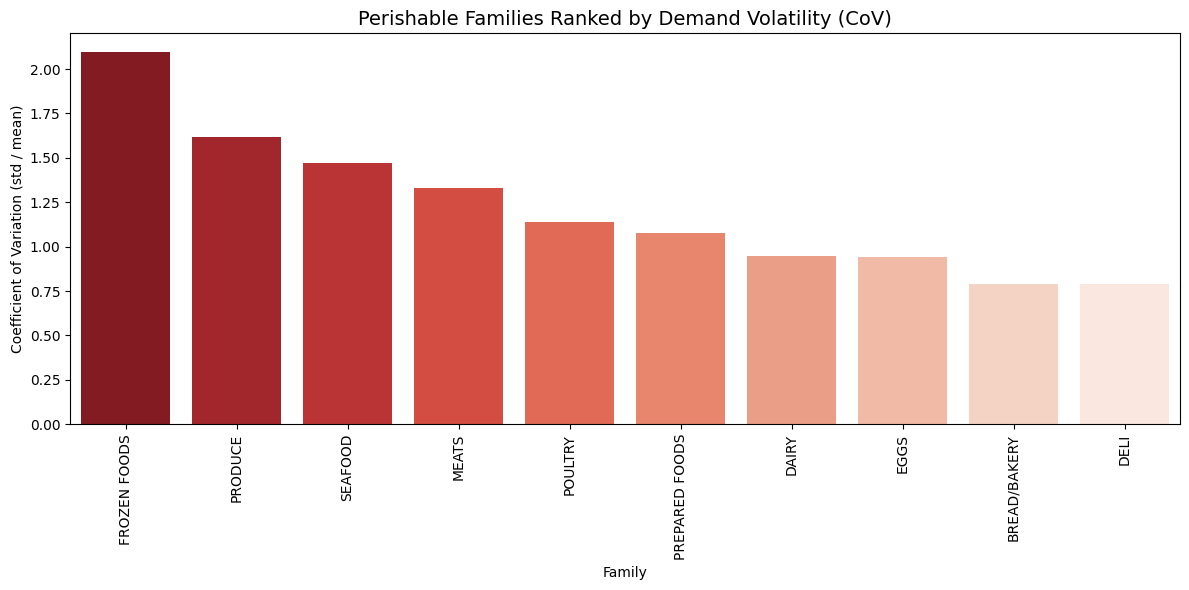

In [77]:
# Perishable Families Ranked by Demand Volatility using Coefficient of Variation (CoV)

# Step 1: Filter perishable families
perishable_df = train_df[train_df['is_perishable'] == 1]

# Step 2: Calculate mean + std dev of daily sales per family
family_stats = (
    perishable_df.groupby('family')['sales']
    .agg(['mean', 'std'])
    .reset_index()
)

# Step 3: Calculate Coefficient of Variation (CoV)
family_stats['cov'] = family_stats['std'] / family_stats['mean']
family_stats = family_stats.sort_values('cov', ascending=False)

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='family', y='cov', data=family_stats, palette='Reds_r')
plt.title('Perishable Families Ranked by Demand Volatility (CoV)', fontsize=14)
plt.xlabel('Family')
plt.ylabel('Coefficient of Variation (std / mean)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



##### Frozen Foods and Produce exhibit the highest demand volatility among perishables, with CoV values above 1.5–2.0, signaling a critical need for agile replenishment and robust safety stock policies.
##### Meats, Seafood, and Prepared Foods also show unstable demand, suggesting that perishable inventory planning should prioritize freshness without overstocking — especially in categories with tight shelf lives and refrigeration dependencies.

## Demand Volatility Across Stores & Families

##### To analyze which stores or families have unstable demand and need tighter control, buffer stock, or responsive replenishment

C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\1031661117.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_volatility, x='store_nbr', y='cov', palette='viridis')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_g

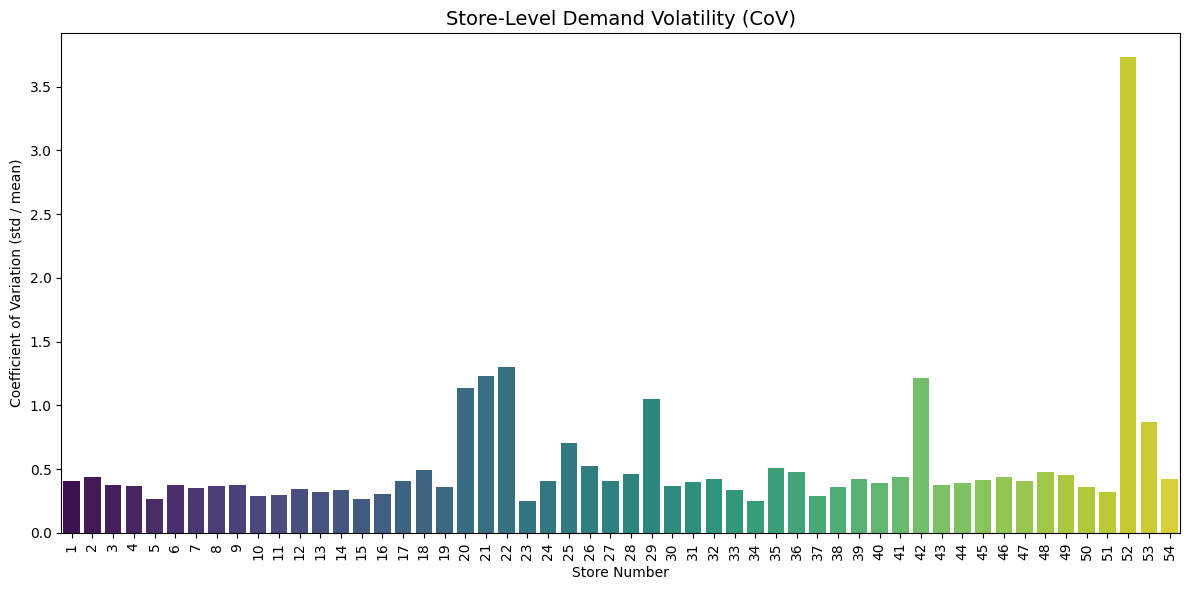

In [78]:
# Demand Volatility by Store

# Step 1: Get daily total sales per store
store_daily = train_df.groupby(['store_nbr', 'date'])['sales'].sum().reset_index()

# Step 2: CoV = std / mean per store
store_volatility = (
    store_daily.groupby('store_nbr')['sales']
    .agg(['mean', 'std'])
    .reset_index()
)
store_volatility['cov'] = store_volatility['std'] / store_volatility['mean']
store_volatility = store_volatility.sort_values('cov', ascending=False)

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=store_volatility, x='store_nbr', y='cov', palette='viridis')
plt.title('Store-Level Demand Volatility (CoV)', fontsize=14)
plt.xlabel('Store Number')
plt.ylabel('Coefficient of Variation (std / mean)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


C:\Users\rezzt\AppData\Local\Temp\ipykernel_23904\1478337880.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=family_volatility, x='family', y='cov', palette='coolwarm')
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rezzt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_gr

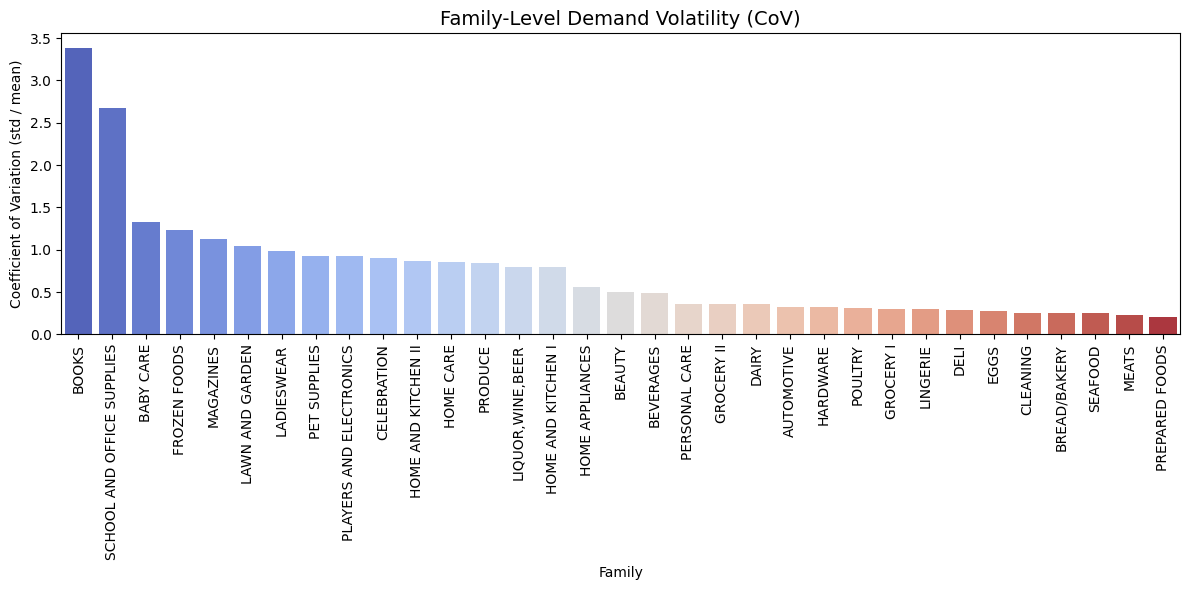

In [79]:
# Demand Volatility by Family

# Step 1: Get daily total sales per family
family_daily = train_df.groupby(['family', 'date'])['sales'].sum().reset_index()

# Step 2: CoV = std / mean per family
family_volatility = (
    family_daily.groupby('family')['sales']
    .agg(['mean', 'std'])
    .reset_index()
)
family_volatility['cov'] = family_volatility['std'] / family_volatility['mean']
family_volatility = family_volatility.sort_values('cov', ascending=False)

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=family_volatility, x='family', y='cov', palette='coolwarm')
plt.title('Family-Level Demand Volatility (CoV)', fontsize=14)
plt.xlabel('Family')
plt.ylabel('Coefficient of Variation (std / mean)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


##### Store #53 stands out as a major outlier with a CoV above 3.5, indicating highly erratic demand that may require customized forecasting, frequent replenishment, or closer investigation into event-driven surges or data anomalies.
##### At the family level, volatility is highest in low-volume categories like Books, School Supplies, and Baby Care, which are likely driven by seasonal spikes or irregular purchasing cycles — making them risky to overstock and better suited to lean inventory strategies.